## House Prices
### Kaggle Competition

Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home

#### Notebook Preparation

In [1]:
# Styling
from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:60% !important; }</style>"))

# Data import
import pandas as pd
import numpy as np
import warnings

# Jupyter notebook settings
%load_ext autotime
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)

time: 317 µs


### Data Preparation

The structure we have is a train a test and a solution file:
 - Train.shape (1460,80)
 - Test.shape (1459,79)
 - Solution.shape(1459,1)
 
In order to simply our dataframe approche and usage, I will concatenate the 3 dataframes, to create:
 - Houses: 
     - Shape: (2919,80)
     
This approach will simplify feature engineering, and to be faire, the split between the train and the test data will be done on 50% of the dataset, to find the same proportions given as the instructions

In [2]:
train_house = pd.read_csv('Data/train.csv',index_col=0)
test_house = pd.read_csv('Data/test.csv',index_col=0)
solution = pd.read_csv('Data/solution.csv',index_col=0)

houses = pd.concat([train_house,test_house])
houses.iloc[1460:,-1:] = solution

time: 76 ms


In [3]:
houses.shape

(2919, 80)

time: 7.09 ms


### Feature Engineering

Feature Engineering, is the process of adapting the types of the variables in our dataset to make better use of our entries.
There are two main data types:
- Numerical
- Categorical

The goal of this project is to predict the price of different housing, based on different features.
Let's go through some analysis on both, our features and the prediction that has to be made

#### Numerical Analysis

After looking at the different numerical values, I decided to analyse two particular relationships:
- GrlvArea / SalePrice
- TotalBsmntSF / SalePrice

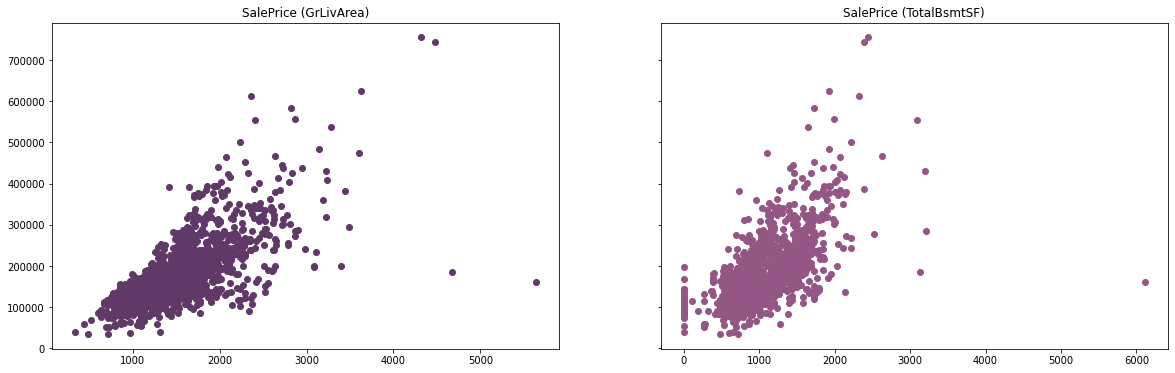

time: 661 ms


In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

#scatter plot grlivarea/saleprice
dt = pd.concat([train_house['SalePrice'], train_house['TotalBsmtSF'], train_house['GrLivArea']], axis=1)

# Create Subplots and setting things up
matplotlib.rcParams['figure.figsize'] = (20.0, 6.0)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.scatter(dt.GrLivArea,dt.SalePrice, color=list(sns.cubehelix_palette(as_cmap=False))[4])
ax1.set_title('SalePrice (GrLivArea)')

ax2.scatter(dt.TotalBsmtSF,dt.SalePrice, color=list(sns.cubehelix_palette(as_cmap=False))[3])
ax2.set_title('SalePrice (TotalBsmtSF)');

We can see that there are two 'extreme' values worth noticing when we compare the SalePrice to the GrvlArea, and one other value when we look at the SalePrice coming from the TotalBsmtSF feature. Those 3 points, really 'stand out' from the crowd and tend to go to another direction, ignoring the approximate linear fit that we can most likely see.
They are outliers
I will then be getting rid of them, in order to have a more *harmonious* SalePrice column

In [5]:
train_house = train_house[(train_house['GrLivArea'] < 4500) & (train_house['TotalBsmtSF'] < 6000)]
train_house.shape

(1458, 80)

time: 14.3 ms


#### Housing prices distribution

We got rid of the outliers, let's know take a look at the SalePrice distribution !

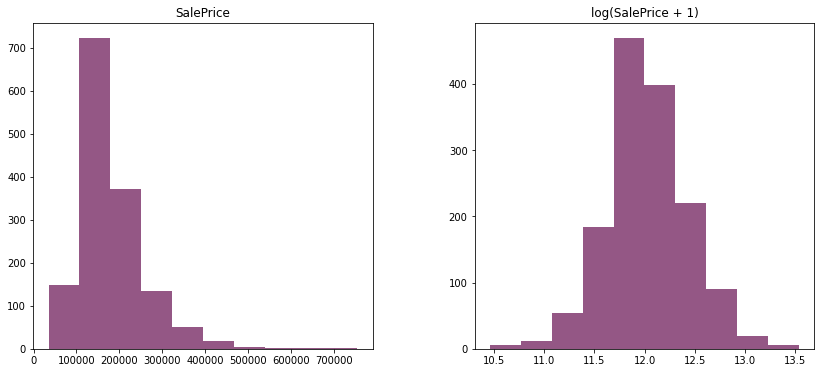

time: 222 ms


In [6]:
# Some styling

matplotlib.rcParams['figure.figsize'] = (14.0, 6.0)

# House pricing distribution creation
prices_dist = pd.DataFrame({"SalePrice":train_house["SalePrice"], "log(SalePrice + 1)":np.log1p(train_house["SalePrice"])})

# Plotting
prices_dist.hist(color=list(sns.cubehelix_palette(as_cmap=False))[3],
                 grid=False);

We can see, that applying the log distribution gives us a better distribution with a lot less skewness.
In fact we'll apply this function to the target values, and get rid of skewness.

In [7]:
#log transform the target:
train_house["SalePrice"] = np.log1p(train_house["SalePrice"])

time: 4.54 ms


After modifying rows, we reset features and labels

In [8]:
# Split features and labels
train_labels = train_house['SalePrice'].reset_index(drop=True)
train_features = train_house.drop(['SalePrice'], axis=1)
test_features = test_house

# Combine train and test features in order to apply the feature transformation pipeline to the entire dataset
houses = pd.concat([train_features, test_features]).reset_index(drop=True)
houses.shape

(2917, 79)

time: 27.8 ms


#### Missing Values

In order to compute missing values, we're going to use the description.txt file given to us.
This file will help us determine the meaning of all missing values according to their corresponding features

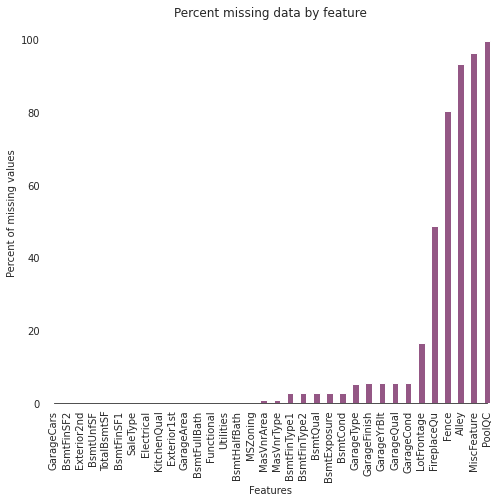

time: 326 ms


In [9]:
def missing_values(df):
    mv = round(df.isna().sum().sort_values(ascending=False)/len(df)*100,2)
    return mv[mv>0]

# Visualize missing values
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')

missing = missing_values(houses)
missing.sort_values(inplace=True)
missing.plot.bar(color=list(sns.cubehelix_palette(as_cmap=False))[3])

# Tweak the visual presentation
ax.xaxis.grid(False)
ax.set(ylabel="Percent of missing values")
ax.set(xlabel="Features")
ax.set(title="Percent missing data by feature")
sns.despine(trim=True, left=True)

#### Handling Missing Values

In [10]:
def handle_missing(features):
    """
    This function handles missing data using info provided from the description.txt file
    """
        
    ## Replace the missing values in each of the columns below with their mode
    
    # Typ refers to Typical
    features['Functional'] = features['Functional'].fillna('Typ')
    # SBrkr refers to Standard Circuit Breakers & Romex
    features['Electrical'] = features['Electrical'].fillna("SBrkr")
    # TA refers to Typical/Average
    features['KitchenQual'] = features['KitchenQual'].fillna("TA")
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    
    # the data description stats that NA refers to "No Pool"
    features["PoolQC"] = features["PoolQC"].fillna("None")
    
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
        
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
        
    # NaN values for these categorical basement features, means there's no basement
    for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
        features[col] = features[col].fillna('None')
        
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # We have no particular intuition around how to fill in the rest of the categorical features
    # So we replace their missing values with None
    objects = []
    for i in features.columns:
        if features[i].dtype == object:
            objects.append(i)
    features.update(features[objects].fillna('None'))
        
    # And we do the same thing for numerical features, but this time with 0s
    numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    numeric = []
    for i in features.columns:
        if features[i].dtype in numeric_dtypes:
            numeric.append(i)
    features.update(features[numeric].fillna(0))    
    return features

houses = handle_missing(houses)

time: 87.8 ms


#### Fix skewed features

In [12]:
from scipy.stats import skew

#log transform skewed numeric features:
numeric_feats = houses.dtypes[houses.dtypes != "object"].index

skewed_feats = houses[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.5]
skewed_feats = skewed_feats.index

houses[skewed_feats] = np.log1p(houses[skewed_feats])

time: 38.9 ms


In [13]:
def categorize(serie):
    return serie.astype('category').cat.codes

# Categorizing the categorical values into integers.
houses[list(houses.select_dtypes(include='object').columns)] = houses.select_dtypes(include='object').apply(categorize,axis=1)

time: 1.18 s


In [14]:
def populate_features(df):
    all_features=df.copy()
    
    all_features['BsmtFinType1_Unf'] = 1*(all_features['BsmtFinType1'] == 'Unf')
    all_features['HasWoodDeck'] = (all_features['WoodDeckSF'] == 0) * 1
    all_features['HasOpenPorch'] = (all_features['OpenPorchSF'] == 0) * 1
    all_features['HasEnclosedPorch'] = (all_features['EnclosedPorch'] == 0) * 1
    all_features['Has3SsnPorch'] = (all_features['3SsnPorch'] == 0) * 1
    all_features['HasScreenPorch'] = (all_features['ScreenPorch'] == 0) * 1
    all_features['YearsSinceRemodel'] = all_features['YrSold'].astype(int) - all_features['YearRemodAdd'].astype(int)
    all_features['Total_Home_Quality'] = all_features['OverallQual'] + all_features['OverallCond']
    all_features = all_features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)
    all_features['TotalSF'] = all_features['TotalBsmtSF'] + all_features['1stFlrSF'] + all_features['2ndFlrSF']
    all_features['YrBltAndRemod'] = all_features['YearBuilt'] + all_features['YearRemodAdd']

    all_features['Total_sqr_footage'] = (all_features['BsmtFinSF1'] + all_features['BsmtFinSF2'] +
                                     all_features['1stFlrSF'] + all_features['2ndFlrSF'])
    all_features['Total_Bathrooms'] = (all_features['FullBath'] + (0.5 * all_features['HalfBath']) +
                                   all_features['BsmtFullBath'] + (0.5 * all_features['BsmtHalfBath']))
    all_features['Total_porch_sf'] = (all_features['OpenPorchSF'] + all_features['3SsnPorch'] +
                                  all_features['EnclosedPorch'] + all_features['ScreenPorch'] +
                                  all_features['WoodDeckSF'])
    all_features['TotalBsmtSF'] = all_features['TotalBsmtSF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    all_features['2ndFlrSF'] = all_features['2ndFlrSF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    all_features['GarageArea'] = all_features['GarageArea'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    all_features['GarageCars'] = all_features['GarageCars'].apply(lambda x: 0 if x <= 0.0 else x)
    all_features['LotFrontage'] = all_features['LotFrontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    all_features['MasVnrArea'] = all_features['MasVnrArea'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    all_features['BsmtFinSF1'] = all_features['BsmtFinSF1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

    all_features['haspool'] = all_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    all_features['has2ndfloor'] = all_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    all_features['hasgarage'] = all_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    all_features['hasbsmt'] = all_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
    all_features['hasfireplace'] = all_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    return all_features

#houses = populate_features(houses)

time: 2.27 ms


In [138]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# In order to correlate with Saleprice, we must add Saleprice to the df
df = houses.copy()
df['SalePrice'] = train_labels

corr = df.iloc[:1460,:].corr()
#f, ax = plt.subplots(figsize=(12, 10))
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=(sns.diverging_palette(220, 20, as_cmap=True)),square=False);

time: 31.4 ms


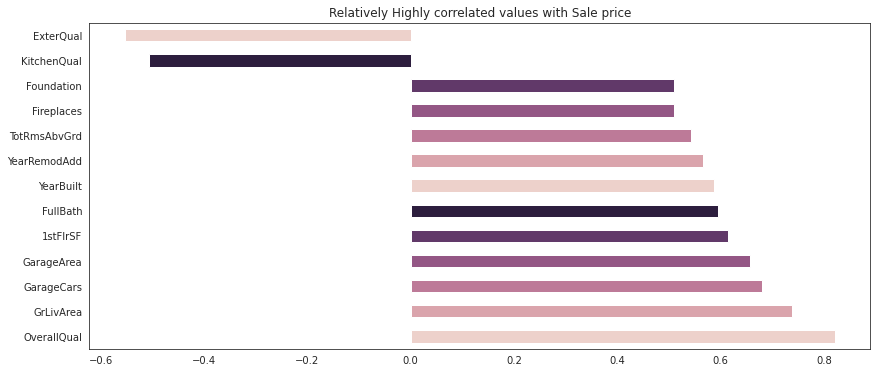

time: 183 ms


In [17]:
spc = corr.iloc[-1].sort_values(ascending=False)
selected_spc = spc[(spc <= -0.5) | (spc >= 0.5)].drop('SalePrice')

selected_spc.plot(kind='barh',
                  title='Relatively Highly correlated values with Sale price',
                  color=list(sns.cubehelix_palette(as_cmap=False)));

## Model Creation

#### Since we merged the train and test data before hand, the split must occur by hand

In order to implement a simple and demonstrative web application I will select some carefully chosen features to train my model on, that way, on the cloud application, the inputs won't be so hard to implement

In [19]:
# X and y are the Common X_train, and y_train arrays, they correspond to the train.csv file
X,y = houses.iloc[:1458,:-1],train_labels

# X_test and y_true correspond, respectively to the test features and their exact SalePrice 
X_test,y_true = houses.iloc[1458:,:-1],solution

time: 6.2 ms


### Model preparation

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error as mse
from math import sqrt

# Define Cross validation params
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Define error metrics
def rmsle(y, y_pred):
    return np.sqrt(mse(y, y_pred))

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

# Initialising a scores dict to store all model rooted mean squared errors
scores = {}

time: 603 µs


### Linear Regressor

In [82]:
from sklearn import metrics

lr = LinearRegression()

scores['Linear Regressor'] = {'mean': round(cv_rmse(lr).mean(),5), 'std': round(cv_rmse(lr).std(),5)}

print("Mean RMSE Linear Regressor: %.5f" %scores['Linear Regressor']['mean'])
print("Std  RMSE Linear Regressor: %.5f" %scores['Linear Regressor']['std'])

Mean RMSE Linear Regressor: 0.12165
Std  RMSE Linear Regressor: 0.01318
time: 479 ms


### Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=18,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=1812)

scores['Random forest Regressor'] = {'mean': round(cv_rmse(rf).mean(),5), 'std': round(cv_rmse(rf).std(),5)}

print("Mean RMSE RF Regressor: %.5f" %scores['Random forest Regressor']['mean'])
print("Std  RMSE RF Regressor: %.5f" %scores['Random forest Regressor']['std'])

Mean RMSE RF Regressor: 0.14168
Std  RMSE RF Regressor: 0.01860
time: 7min 3s


### Gradient Boosting Regressor

In [86]:
from sklearn.ensemble import GradientBoostingRegressor
# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=1812)  

scores['GradientBoosting Regressor'] = {'mean': round(cv_rmse(gbr).mean(),5), 'std': round(cv_rmse(gbr).std(),5)}

print("Mean RMSE GB Regressor: %.5f" %scores['GradientBoosting Regressor']['mean'])
print("Std  RMSE GB Regressor: %.5f" %scores['GradientBoosting Regressor']['std'])

Mean RMSE GB Regressor: 0.11619
Std  RMSE GB Regressor: 0.01633
time: 6min 46s


### Model Stacking

In [101]:
from mlxtend.regressor import StackingCVRegressor

# Stack up all the models above, optimized using Gradient boosting Regressor
stack_m = StackingCVRegressor(regressors=(gbr, lr, rf),
                              meta_regressor=gbr,
                              use_features_in_secondary=True)

scores['Stacked model'] = {'mean': round(cv_rmse(stack_m).mean(),5), 'std': round(cv_rmse(stack_m).std(),5)}

time: 1h 21min 36s


In [135]:
# Visualising performance on cross validation

d_scores = pd.DataFrame.from_dict(scores).transpose()
d_scores.to_csv('nov4-end1-results.csv',index=True)

time: 11.4 ms


### Model Selection

In [110]:
# Arguably, stack_m fits and predicts the best, as we can see in the above dataframe, I'll then use it for my predictions
stack_m.fit(X,y)

y_pred = stack_m.predict(X_test)

time: 3min 33s


In [136]:
submission = pd.DataFrame(np.floor(np.expm1(y_pred)),columns=['SalePrice'], index=pd.Index(np.arange(1461,2920), name='Id'))
#submission
# Submitting to csv in order to upload to Kaggle!
submission.to_csv("submission_HanyAky.csv", index=True)

time: 14.2 ms
